In [1]:
import numpy, pandas
from matplotlib import pyplot

### Create high-dimensional dataset

In [2]:
def getCovarianceMatrix(number_of_dimensions):
    """
    Returns a random, symmetric, and positive-semidefinite matrix 
    """
    matrix = numpy.random.rand(number_of_dimensions, number_of_dimensions)-0.5
    return numpy.dot(matrix, matrix.transpose())

def getPoints(number_of_dimensions, number_of_points, mean_gain = 100, covariance_gain = 1000):
    """
    Returns random points with a random mean and covariance
    """
    mean = numpy.random.rand(number_of_dimensions)*mean_gain
    cov = getCovarianceMatrix(number_of_dimensions)*covariance_gain
    return numpy.random.default_rng().multivariate_normal(mean, cov, number_of_points)

def unison_shuffle(a, b):
    """
    Returns shuffled versions of the inputs, where the shuffled order is the same for both inputs  
    """
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

def getLabeledData(
    number_of_dimensions, 
    number_of_clusters, 
    min_number_of_points_in_cluster, 
    max_number_of_points_in_cluster,
    min_mean_gain,
    max_mean_gain,
    min_cov_gain,
    max_cov_gain):
    """
    Returns dataset and labels 
    """
    cluster_points = []
    cluster_ids = []
    for cluster_id in range(number_of_clusters):
        number_of_points = numpy.random.randint(min_number_of_points_in_cluster, max_number_of_points_in_cluster)
        mean_gain = numpy.random.randint(min_mean_gain, max_mean_gain)
        cov_gain = numpy.random.randint(min_cov_gain, max_cov_gain)
        cluster_points.append(getPoints(number_of_dimensions, number_of_points, mean_gain, cov_gain))
        cluster_ids.append(numpy.ones(number_of_points)*cluster_id)
    dataset = numpy.concatenate(cluster_points)
    labels = numpy.concatenate(cluster_ids)
    dataset, labels = unison_shuffle(dataset, labels)
    return dataset, labels

In [3]:
dataset, dataset_labels = getLabeledData(
    number_of_dimensions=30,
    number_of_clusters=10,
    min_number_of_points_in_cluster=100,
    max_number_of_points_in_cluster=1000,
    min_mean_gain=1,
    max_mean_gain=100,
    min_cov_gain=1,
    max_cov_gain=10
)

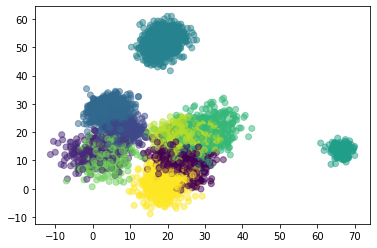

In [4]:
# Shows 2D projection of the points colored by cluster
pyplot.scatter(dataset.T[0], dataset.T[1], c=dataset_labels, alpha=0.5)

### Use T-sne for dimensionality reduction

In [5]:
from sklearn.manifold import TSNE

In [6]:
def normalise(feature_matrix):
    amplitudes = numpy.sum(feature_matrix,axis=0)
    return numpy.divide(feature_matrix, amplitudes)


In [7]:
hold_out_index = int(len(dataset_labels)*9/10)
feature_matrix = normalise(dataset[:hold_out_index])

model = TSNE()
model.set_params(**{
         'angle':                   0.5,           # Barnes_hut angle, 0.2 - 0.8
         'early_exaggeration':      12.0,
         'init':                    'random',      # 'pca' or 'random'
         'learning_rate':           200,
         'method':                  'barnes_hut',  # 'exact' or 'barnes_hut'
         'metric':                  'euclidean',
         'min_grad_norm':           1e-07,
         'n_components':            2,
         'n_iter':                  300,
         'n_iter_without_progress': 1000,
         'perplexity':              30,          # Usually 5-50
         'random_state':            None,
         'verbose':                 0,
         'n_jobs':                  4
})
embedding = model.fit_transform(feature_matrix)

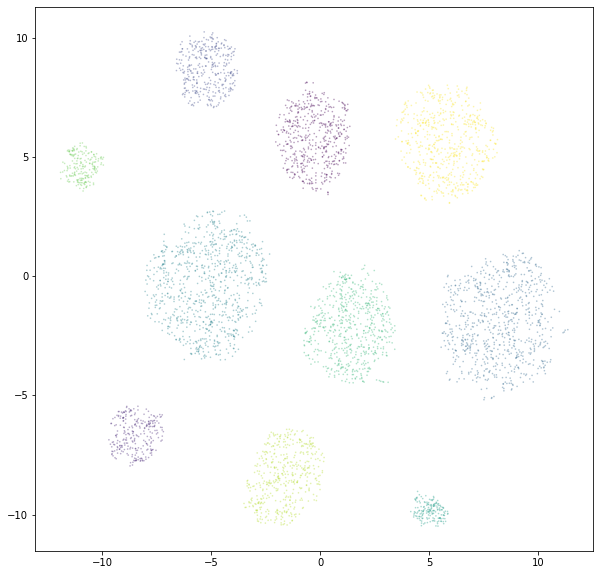

In [8]:
# Plot the embedded points
fig = pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(embedding.T[0], embedding.T[1], s=0.5, c=dataset_labels[:hold_out_index], alpha=0.3)


#pyplot.scatter(embedding.T[0], embedding.T[1], s=0.1, c=labels[:hold_out_index], alpha=0.5)

### Use waterfall to partition the 2D space

In [9]:
from sklearn.neighbors import KernelDensity
from matplotlib import pyplot
from scipy import stats
from skimage.feature import peak_local_max
from scipy.ndimage import label
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy.spatial import distance_matrix

In [10]:
from sklearn.neighbors import KernelDensity
def getDensity(x, y, nbins=None, bandwidth=40.0, xbins=300j, ybins=300j, padding=0.2, **kwargs): 
    # For backwards compatibility
    if nbins is not None:
        xbins=nbins*1j
        ybins=nbins*1j

    # create grid of sample locations (default: 100x100)
    xmin = x.min() - numpy.abs(x.min())*padding
    xmax = x.max() + numpy.abs(x.max())*padding
    ymin = y.min() - numpy.abs(y.min())*padding
    ymax = y.max() + numpy.abs(y.max())*padding
    xx, yy = numpy.mgrid[xmin:xmax:xbins, 
                      ymin:ymax:ybins]

    xy_sample = numpy.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = numpy.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = numpy.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, numpy.reshape(z, xx.shape)

import numpy
from scipy import stats
def transformLevels(zz, levels=256):
    new_matrix = numpy.zeros(shape=zz.shape, dtype='int')
    scale_z = levels/(zz.max()-zz.min())
    bias = zz.min()
    for x in range(zz.shape[0]):
        for y in range(zz.shape[1]):
            new_matrix[x,y] = int((zz[x,y]-bias)*scale_z)
    return new_matrix

def getPeaks(xx, yy, zz, min_distance):
    new_matrix = transformLevels(zz)
    while min_distance > 0:
        try:
            peaks = peak_local_max(new_matrix,
                               min_distance=min_distance,
                               threshold_abs=None,
                               threshold_rel=None,
                               exclude_border=True,
                               indices=True,
                               num_peaks=1000,
                               footprint=None,
                               labels=None,
                               num_peaks_per_label=1000)
            p = numpy.zeros(shape=peaks.shape)
            for i in range(len(peaks)):
                p[i] = [ xx[peaks[i][0],0], yy[0,peaks[i][1]] ]
            return reducePointList(p)
        except ValueError as e:
            print('Reducing min_distance to {}'.format(min_distance))
            min_distance -= 1

def getLabels(xx, yy, zz, peaks):
    new_matrix = transformLevels(zz)
    out = numpy.zeros(shape=new_matrix.shape)
    i = 1
    for peak in peaks:
        x = numpy.searchsorted(xx[:,0], peak[0], side="left")
        y = numpy.searchsorted(yy[0,:], peak[1], side="left")
        out[x,y] = i
        i += 1
    return out

from skimage.segmentation import watershed
def getRegions(xx,yy,zz, **kwargs):
    new_matrix = transformLevels(zz)
    regions = watershed((256-new_matrix), mask=(new_matrix>0), watershed_line=False, **kwargs)
    return regions

def getBorders(xx,yy,zz, markers=None):
    new_matrix = transformLevels(zz)
    borders = watershed((256-new_matrix), markers=markers, compactness=10, mask=(new_matrix>0), watershed_line=True)
    for x in range(borders.shape[0]):
        for y in range(borders.shape[1]):
            if borders[x,y] == 0:
                borders[x,y] = 256
            else:
                borders[x,y] = 0
    return borders

def reducePointList(p, min_distance=3): # min_distance must be relative to the embedded points
    while True:
        d = getDistanceMatrix(p)
        distance, indices = findSmallestDistance(d)
        if distance < min_distance:
            p = numpy.delete(p,indices[0],axis=0)
        else:
            return p

def getDistanceMatrix(p):
    d = distance_matrix(p,p, p=2, threshold=1000000)
    max = d.max()*10
    for i in zip(range(len(d)),range(len(d))):
        d[i] = max
    return d

def findSmallestDistance(d):
    return d.min(), numpy.unravel_index(numpy.argmin(d, axis=None), d.shape)


In [11]:
bw = numpy.mean([numpy.max(embedding.T[0])-numpy.min(embedding.T[0]), numpy.max(embedding.T[1])-numpy.min(embedding.T[1])])/15
print('Setting bandwidth to {}'.format(bw))
xx, yy, zz = getDensity(
    embedding.T[0],
    embedding.T[1],
    xbins = 300j,
    ybins = 300j,
    padding = 0.2,
    bandwidth = bw,
    kernel='gaussian', #'linear'
    metric='euclidean')


Setting bandwidth to 1.466498311360677


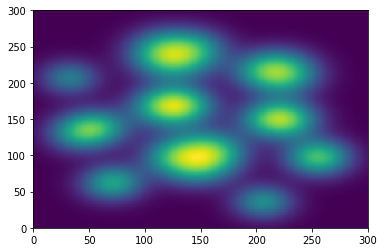

In [12]:
#pyplot.pcolormesh(xx,yy,zz, shading='auto')
pyplot.pcolor(transformLevels(zz))

In [13]:
print('Finding peaks')
peaks = getPeaks(xx,yy,zz, min_distance=20)
print('Creating labels')
labels = getLabels(xx,yy,zz,peaks)
print('Creating regions')
regions = getRegions(xx,yy,zz,markers=labels, compactness=10)
print('Drawing borders')
borders = getBorders(xx,yy,zz,labels)
print('Done')

Finding peaks
Creating labels
Creating regions
Drawing borders
Done


<ipython-input-15-f5de2e4212f9>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx,yy,zz, cmap='jet')
<ipython-input-15-f5de2e4212f9>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)


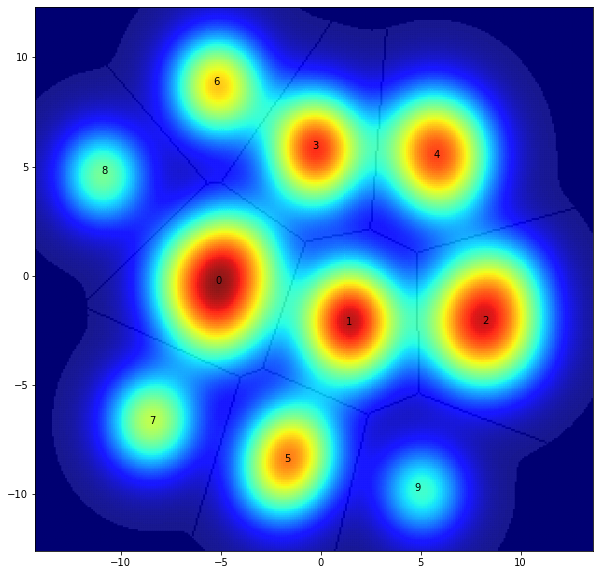

In [15]:
fig = pyplot.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.pcolormesh(xx,yy,zz, cmap='jet')
ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)
for i, peak in enumerate(peaks):
    ax.text(peak[0],peak[1], i, horizontalalignment='center')
#ax.axis('off')

### Post-embed the remaining points in the model

In [16]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
from scipy.spatial import distance
from scipy.optimize import minimize

In [17]:
def testPoint(point):
    if point[0] < bounding_box[0][0]:
        return False
    elif point[0] > bounding_box[0][1]:
        return False
    elif point[1] < bounding_box[1][0]:
        return False
    elif point[1] > bounding_box[1][1]:
        return False
    else:
        return True

def getEmbeddingForAdditionalPoints(new_feature_matrix):
    out = numpy.zeros((new_feature_matrix.shape[0],2))
    for i in range(new_feature_matrix.shape[0]):
        print( str(i) + ' of ' + str(new_feature_matrix.shape[0]) )
        new_embedding = getEmbeddingForAdditionalPoint(new_feature_matrix[i])
        if testPoint(new_embedding):
            print('New embedding',new_embedding)
            out[i] = new_embedding
        else:
            print('Point ' + str(i) + ' with coordinates ' + str(new_embedding) + ' could not be embedded')
            out[i] = numpy.zeros(2)
    return out

def getNearestNeighbors(z):
    return nbrs.kneighbors(z.reshape(1, -1))

def getP_jz(X, z, sigma_z):
    tolerance = 1e-9
    denominator = 0
    for x in X:
        denominator += numpy.sum( numpy.exp( -(entropy(z,x)**2) / (2*(sigma_z**2))) )

    if denominator < tolerance:
        denominator = tolerance

    P_jz = numpy.empty((0,1))
    for j in X:
        numerator = numpy.sum( numpy.exp( -(entropy(z,j)**2) / (2*(sigma_z**2))) )
        P_jz = numpy.append( P_jz, numerator / denominator )
    P_jz[P_jz < 1e-20] = 1e-20
    return P_jz

def getEmbeddingForAdditionalPoint(z, n_centroid=10):
    # Find nearest neighbors
    distances, indices = nbrs.kneighbors(z.reshape(1, -1))

    # Get embeddings for the neighbors
    X = feature_matrix[indices][0] # X
    X_tick = embedding[indices][0] # X'

    # Estimate sigma
    sigma_z = getSigma(X, z, distances[0])

    # Calculate transition probabilities  P_j|z
    P_jz = getP_jz(X, z, sigma_z)

    # Start from centroid of 10 nearest points
    zeta = numpy.mean(embedding[indices[0:n_centroid]][0],axis=0)
    print("Starting point",zeta)
    res = minimize(
        evaluate_zeta,
        zeta,
        args=(X_tick, P_jz),
        method='Nelder-Mead',
        tol=1e-9,
        options={'maxiter':n_iter,'adaptive':False})
    
    return res.x


def evaluate_zeta(zeta, X_tick, P_jz):
    # Calculate q_j|zeta
    denominator = 0
    for x_tick in X_tick:
        denominator += (1 + distance.euclidean(zeta, x_tick)**2)**-1

    q_jzeta = numpy.empty((0,1))
    for j in X_tick:
        numerator = (1 + distance.euclidean(zeta,j)**2)**-1
        q_jzeta = numpy.append( q_jzeta, numerator / denominator)

    return -entropy(P_jz,q_jzeta)

def getSigma(X, z, ds, maxNeighbors=30, perplexity=25, n_iter=500, tolerance=1e-3):
    s = ds.shape[0]
    highGuess = numpy.max(ds)
    prev_high = highGuess + 1
    lowGuess = 1e-20
    prev_low = lowGuess - 1

    sigma = .5*(highGuess + lowGuess)

    P_jz = getP_jz(X, z, sigma)
    H = - numpy.sum( numpy.multiply( P_jz, numpy.log2(P_jz) ))
    P = 2**H

    if numpy.abs(P-perplexity) < tolerance:
        test = False
    else:
        test = True

    i = 0
    while test:
        if P > perplexity:
            highGuess = sigma
        else:
            lowGuess = sigma

        sigma = .5*(highGuess + lowGuess)

        P_jz = getP_jz(X, z, sigma)
        H = - numpy.sum( numpy.multiply( P_jz, numpy.log2(P_jz) ))
        P = 2**H

        diff = numpy.abs(P-perplexity)
        if diff < tolerance:
            print('Sigma converged')
            test = False

        if i > n_iter or (highGuess == prev_high and lowGuess == prev_low):
            print('Sigma is not converging', P, diff)
            test = False
            
        #if i%100:
        #    print(sigma, P, diff, highGuess, lowGuess)

        i += 1
        prev_high = highGuess
        prev_low = lowGuess
    print("Sigma", sigma, "found after",i,"iterations")
    return sigma

In [18]:
n_iter = 500
tolerance = 1e-7
n_neighbors = int(30) #perplexity
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(feature_matrix)

bounding_box = [[0,0], [0,0]]
print(bounding_box)
bounding_box[0][0] = numpy.min(embedding.T[0]) # x min
print(bounding_box)
bounding_box[0][1] = numpy.max(embedding.T[0]) # x max
print(bounding_box)
bounding_box[1][0] = numpy.min(embedding.T[1]) # y min
print(bounding_box)
bounding_box[1][1] = numpy.max(embedding.T[1]) # y max
print(bounding_box)

new_feature_matrix = normalise(dataset[hold_out_index:])
post_embedding = getEmbeddingForAdditionalPoints(new_feature_matrix)

[[0, 0], [0, 0]]
[[-11.9045105, 0], [0, 0]]
[[-11.9045105, 11.360914], [0, 0]]
[[-11.9045105, 11.360914], [-10.482188, 0]]
[[-11.9045105, 11.360914], [-10.482188, 10.247337]]
0 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0030147169178878514 found after 53 iterations
Starting point [-2.2450893 -7.713536 ]
New embedding [ -1.54588618 -10.36107796]
1 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005652797927969563 found after 53 iterations
Starting point [-8.309469 -6.214638]
New embedding [-9.75197143 -5.80730059]
2 of 530
Sigma is not converging 1.0 24.0
Sigma 0.013982108024617846 found after 53 iterations
Starting point [-8.433381 -6.099775]
New embedding [-9.54300898 -5.52923214]
3 of 530
Sigma is not converging 1.0 24.0
Sigma 0.00503532097832125 found after 53 iterations
Starting point [-8.54123   -6.3093176]
New embedding [-9.38505641 -5.49164952]
4 of 530
Sigma is not converging 8.939130222140417 16.060869777859583
Sigma 0.015347611211083648 found after 53 iterations
Starting

New embedding [4.99311379 8.04276535]
46 of 530
Sigma is not converging 1.0 24.0
Sigma 0.009717854105437726 found after 54 iterations
Starting point [-8.226819 -6.014741]
New embedding [-9.38585982 -5.51513062]
47 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005638484986739975 found after 55 iterations
Starting point [-8.356656 -6.168875]
New embedding [-9.99085923 -6.32854145]
48 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0055422069362723834 found after 53 iterations
Starting point [-8.673104  -6.0309615]
New embedding [-9.970992   -6.60577114]
49 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012388854880402148 found after 55 iterations
Starting point [-8.330104 -6.206415]
New embedding [-9.76862826 -7.40916186]
50 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01497361290086915 found after 53 iterations
Starting point [5.203034 5.858403]
New embedding [6.66747268 3.40242041]
51 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005878096463376425 found after 53 iterations
Sta

New embedding [-9.7608006  -5.85280261]
94 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005721658285294813 found after 53 iterations
Starting point [-8.704748 -6.082283]
New embedding [-9.94951007 -6.71056256]
95 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0048782103540177275 found after 54 iterations
Starting point [-8.403566  -6.2846293]
New embedding [-9.34904502 -5.47461866]
96 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01393828929646592 found after 53 iterations
Starting point [-8.354     -6.1264706]
New embedding [-9.55022388 -5.52237087]
97 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012363698866511338 found after 53 iterations
Starting point [-8.320239  -6.1819696]
New embedding [-9.87243247 -6.18802474]
98 of 530
Sigma is not converging 1.0 24.0
Sigma 0.004755322345377053 found after 53 iterations
Starting point [-8.52921 -6.18616]
New embedding [-9.47559183 -5.59473255]
99 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01230485261758681 found after 53 iterati

Sigma is not converging 1.0 24.0
Sigma 0.006145703279161158 found after 53 iterations
Starting point [-8.4933405 -6.0998178]
New embedding [-9.87211444 -5.99443566]
142 of 530
Sigma is not converging 1.0 24.0
Sigma 0.006536960185331047 found after 55 iterations
Starting point [-8.606852 -6.060232]
New embedding [-9.89626117 -6.09127032]
143 of 530
Sigma is not converging 1.0 24.0
Sigma 0.006015101783684517 found after 53 iterations
Starting point [-8.391997 -6.054791]
New embedding [-9.87633201 -6.1534721 ]
144 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012379177221445652 found after 55 iterations
Starting point [-8.39965   -6.2448406]
New embedding [-9.27465458 -5.46110166]
145 of 530
Sigma is not converging 1.0 24.0
Sigma 0.004238830491395944 found after 54 iterations
Starting point [-8.541412 -6.459392]
New embedding [-9.68259011 -5.79644904]
146 of 530
Sigma is not converging 1.0 24.0
Sigma 0.010004930893688022 found after 53 iterations
Starting point [-8.459694 -5.883559]
New

New embedding [-9.73542398 -5.81808287]
188 of 530
Sigma is not converging 1.0 24.0
Sigma 0.014932866627602435 found after 55 iterations
Starting point [5.1765933 6.001123 ]
New embedding [6.66096884 3.40561652]
189 of 530
Sigma is not converging 1.0 24.0
Sigma 0.013330489126676556 found after 53 iterations
Starting point [-8.450959 -6.138838]
New embedding [-9.49698591 -5.52223428]
190 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005876212559965201 found after 53 iterations
Starting point [-8.388607  -6.2301893]
New embedding [-9.67925077 -5.69966262]
191 of 530
Sigma is not converging 1.0 24.0
Sigma 0.010057437319079005 found after 54 iterations
Starting point [-8.340303  -6.0426974]
New embedding [-9.77494961 -5.90648542]
192 of 530
Sigma is not converging 1.0 24.0
Sigma 0.014317177583863309 found after 53 iterations
Starting point [5.093704  5.7929735]
New embedding [6.67690113 3.40432971]
193 of 530
Sigma is not converging 1.0 24.0
Sigma 0.004338655555464579 found after 54 iter

New embedding [-9.66668975 -7.7394111 ]
235 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005690984293429215 found after 55 iterations
Starting point [-8.3501    -6.0832505]
New embedding [-9.59753178 -5.65417791]
236 of 530
Sigma is not converging 8.011522959976094 16.988477040023906
Sigma 0.014604876198955914 found after 53 iterations
Starting point [4.794166  5.6979346]
New embedding [6.74444185 3.50867346]
237 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005707476413453852 found after 53 iterations
Starting point [-8.29162   -6.1279435]
New embedding [-9.66283768 -5.68919328]
238 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01356304630595484 found after 53 iterations
Starting point [-8.517943 -6.117089]
New embedding [-9.47917077 -5.5228594 ]
239 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005834070607059443 found after 55 iterations
Starting point [-8.216238  -6.2363467]
New embedding [-9.72285677 -5.79071592]
240 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0058179

New embedding [-9.72815595 -5.73074521]
282 of 530
Sigma converged
Sigma 0.004614045275771305 found after 14 iterations
Starting point [  5.4285355 -10.150655 ]
Point 282 with coordinates [  5.98101302 -10.89612841] could not be embedded
283 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012705252672419173 found after 53 iterations
Starting point [-8.482613  -6.3620496]
New embedding [-9.67137473 -7.6367294 ]
284 of 530
Sigma is not converging 7.407214713066615 17.592785286933385
Sigma 0.01494173370575894 found after 53 iterations
Starting point [4.872925  5.6163435]
New embedding [6.7687089  3.54902712]
285 of 530
Sigma is not converging 1.0 24.0
Sigma 0.014812931167675038 found after 55 iterations
Starting point [4.88945   5.5278873]
New embedding [4.52681353 3.52820508]
286 of 530
Sigma is not converging 1.0 24.0
Sigma 0.006171482948264709 found after 55 iterations
Starting point [-8.389187 -6.034981]
New embedding [-9.86713627 -6.00590737]
287 of 530
Sigma is not converging 1.0 24

New embedding [-9.3437412  -5.42576162]
328 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0026183406246738346 found after 55 iterations
Starting point [-8.44532 -6.08978]
New embedding [-9.90629465 -6.17479582]
329 of 530
Sigma is not converging 1.0 24.0
Sigma 0.009946966427424382 found after 54 iterations
Starting point [-8.364114 -6.037203]
New embedding [-9.44968979 -5.52517828]
330 of 530
Sigma is not converging 1.0 24.0
Sigma 0.004637346767272923 found after 54 iterations
Starting point [-8.535624 -6.145221]
New embedding [-9.63261679 -5.6677102 ]
331 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012362614722952543 found after 53 iterations
Starting point [-8.3833065 -6.2718005]
New embedding [-9.71344881 -7.40091481]
332 of 530
Sigma is not converging 5.8796334102685135 19.120366589731486
Sigma 0.020724630175278723 found after 53 iterations
Starting point [-8.221022 -6.564898]
New embedding [-9.70240846 -7.68123031]
333 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01519268

New embedding [-9.48240928 -5.56662444]
375 of 530
Sigma is not converging 1.0 24.0
Sigma 0.009160863036883026 found after 53 iterations
Starting point [-8.35264   -6.1391206]
New embedding [-9.47870702 -5.53968374]
376 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012044540261855485 found after 53 iterations
Starting point [-8.362633  -6.2853775]
New embedding [-9.16740017 -5.43949979]
377 of 530
Sigma is not converging 1.0 24.0
Sigma 0.004590458758470561 found after 54 iterations
Starting point [-8.353506 -6.086402]
New embedding [-9.58071288 -5.61953493]
378 of 530
Sigma is not converging 1.0 24.0
Sigma 0.006256341389182714 found after 55 iterations
Starting point [-8.368708 -6.189557]
New embedding [-9.53666654 -5.60277152]
379 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012324383288706334 found after 53 iterations
Starting point [-8.4342985 -6.323385 ]
New embedding [-8.98031495 -5.34022847]
380 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012164634209719596 found after 5

Sigma is not converging 1.0 24.0
Sigma 0.014818322333852371 found after 53 iterations
Starting point [4.8476324 5.898557 ]
New embedding [4.84381644 3.11716121]
422 of 530
Sigma is not converging 1.0 24.0
Sigma 0.012323928859680512 found after 55 iterations
Starting point [-8.425625 -6.27391 ]
New embedding [-9.65344668 -7.47611407]
423 of 530
Sigma is not converging 1.0 24.0
Sigma 0.009580502489676797 found after 53 iterations
Starting point [-8.369509  -6.0434136]
New embedding [-9.38767133 -5.49918402]
424 of 530
Sigma is not converging 10.390513208001588 14.609486791998412
Sigma 0.015257293516233651 found after 53 iterations
Starting point [4.7919397 5.7213607]
New embedding [6.70926579 3.45087263]
425 of 530
Sigma is not converging 1.0 24.0
Sigma 0.006022905654901661 found after 55 iterations
Starting point [-8.354169  -6.2170863]
New embedding [-9.74353341 -5.7733363 ]
426 of 530
Sigma is not converging 1.0 24.0
Sigma 0.014586783333056352 found after 53 iterations
Starting point 

Sigma is not converging 1.0 24.0
Sigma 0.01494731287118791 found after 53 iterations
Starting point [5.01899   5.6045227]
New embedding [6.68255165 3.38664099]
469 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005787754837398362 found after 55 iterations
Starting point [-8.524191 -6.044073]
New embedding [-9.89548099 -6.09661538]
470 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0056428707135576725 found after 55 iterations
Starting point [-8.437448  -6.1459985]
New embedding [-9.64471683 -5.67397398]
471 of 530
Sigma is not converging 1.0 24.0
Sigma 0.01359327293996826 found after 55 iterations
Starting point [-8.4205675 -6.114818 ]
New embedding [-9.52295202 -5.50183636]
472 of 530
Sigma is not converging 1.0 24.0
Sigma 0.005997581731459561 found after 53 iterations
Starting point [-8.396195 -6.12726 ]
New embedding [-9.57019394 -5.66707703]
473 of 530
Sigma is not converging 1.0 24.0
Sigma 0.0067777230004236085 found after 55 iterations
Starting point [-8.647091  -6.0189486]
New

New embedding [-9.68986348 -5.72620695]
516 of 530
Sigma is not converging 1.0 24.0
Sigma 0.015221007399833255 found after 55 iterations
Starting point [4.9845476 6.170552 ]
New embedding [4.72379808 8.01404359]
517 of 530
Sigma is not converging 10.041094666308537 14.958905333691463
Sigma 0.014667363162255375 found after 53 iterations
Starting point [5.0379343 5.9004235]
New embedding [6.53511578 3.41535915]
518 of 530
Sigma is not converging 1.0 24.0
Sigma 0.021053896274621793 found after 55 iterations
Starting point [-7.9832873 -6.6853776]
New embedding [-8.02351061 -8.02568891]
519 of 530
Sigma is not converging 1.0 24.0
Sigma 0.009478003045366477 found after 54 iterations
Starting point [-8.339403 -5.963003]
New embedding [-9.54546512 -5.57252865]
520 of 530
Sigma converged
Sigma 0.002683507981495873 found after 12 iterations
Starting point [  5.401012 -10.166635]
New embedding [  6.53799814 -10.04238698]
521 of 530
Sigma is not converging 7.69440339801891 17.30559660198109
Sigma 

In [19]:
from copy import deepcopy
t_post_embedding = deepcopy(post_embedding)

# Scale to image coordinates
x_scale = ( (zz.shape[0]-1) / (numpy.max(xx) - numpy.min(xx)))
y_scale = ( (zz.shape[1]-1) / (numpy.max(yy) - numpy.min(yy)))
x_offset = ( 0 - xx.min() )
y_offset = ( (zz.shape[1] - 1) + yy.min() )

for row_i in range(post_embedding.shape[0]):
    x = ( post_embedding[row_i] - x_offset) * x_scale
    y = ( post_embedding[row_i] - y_offset) * y_scale 
    t_post_embedding[row_i] = x
    t_post_embedding[row_i] = y

In [20]:
t_post_embedding = deepcopy(post_embedding)

<ipython-input-21-035d2aa5355a>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx,yy,zz, cmap='jet')
<ipython-input-21-035d2aa5355a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)


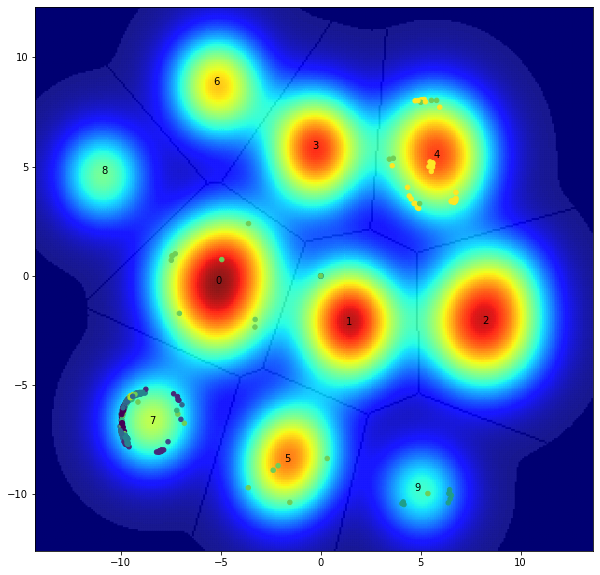

In [21]:
fig = pyplot.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.pcolormesh(xx,yy,zz, cmap='jet')
ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)
for i, peak in enumerate(peaks):
    ax.text(peak[0],peak[1], i, horizontalalignment='center')
ax.scatter(t_post_embedding.T[0], t_post_embedding.T[1], s=20, c=dataset_labels[hold_out_index:], alpha=1)
#ax.axis('off')

In [22]:
from copy import deepcopy
t_embedding = deepcopy(embedding)

# Scale to image coordinates
x_scale = ( (zz.shape[0]-1) / (numpy.max(xx) - numpy.min(xx)))
y_scale = ( (zz.shape[1]-1) / (numpy.max(yy) - numpy.min(yy)))
x_offset = ( 0 - xx.min() )
y_offset = ( (zz.shape[1] - 1) + yy.min() )

for row_i in range(embedding.shape[0]):
    x = ( embedding[row_i] - x_offset) * x_scale
    y = ( embedding[row_i] - y_offset) * y_scale 
    t_embedding[row_i] = x
    t_embedding[row_i] = y

In [23]:
t_embedding = deepcopy(embedding)

<ipython-input-24-6c05db81f835>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx,yy,zz, cmap='jet')
<ipython-input-24-6c05db81f835>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)


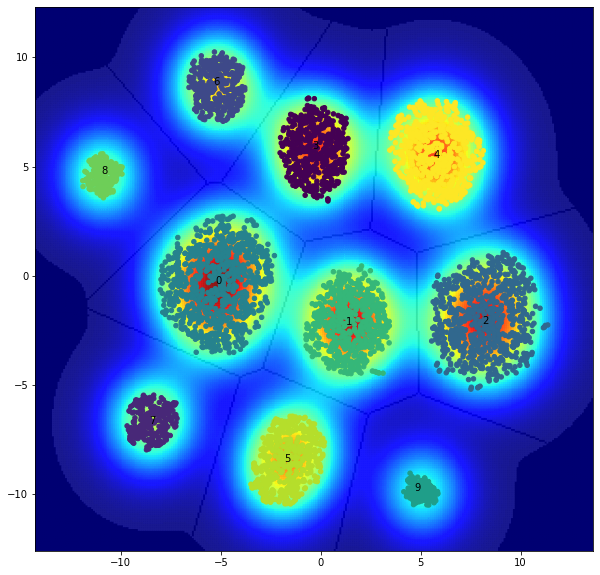

In [24]:
fig = pyplot.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.pcolormesh(xx,yy,zz, cmap='jet')
ax.pcolor(xx,yy,borders, alpha=0.1, cmap='binary', edgecolors=None)
for i, peak in enumerate(peaks):
    ax.text(peak[0],peak[1], i, horizontalalignment='center')
ax.scatter(t_embedding.T[0], t_embedding.T[1], s=20, c=dataset_labels[:hold_out_index], alpha=1)
#ax.scatter(post_embedding.T[0], post_embedding.T[1], s=20, c=dataset_labels[hold_out_index:], alpha=1)
#ax.axis('off')